In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib notebook
import random
from os import listdir, mkdir, getcwd
from os.path import isfile, join, isdir


In [28]:
skip_rows = 10 
bin_num = 0 #enter 0 for maximum bin number; else enter some other number

file_loc = 'C:/Data/2020/08/20200806/spectra/'
save_loc = getcwd().replace("\\", r"/") + r'/plots/'

b_fields = ['4.062', '4.064', '4.066']
title_str = [] #leave empty for autofill date from file names
x_wavelength = False #if true, plot x axis in wavelength, if false, plot in frequency

In [17]:

def grab_data(datfile):
    wavelength, N = np.loadtxt(datfile, unpack=True, skiprows=skip_rows)
    data = np.zeros([2, len(wavelength)])
    data[0,:] = wavelength
    data[1,:] = N

    #Don't plot initialization 0's
    mask = (data==0).all(0)
    start_idx = np.argmax(~mask)
    data = data[:,start_idx:]
    return data

def bin_data(data, dmin, dmax,bn):
    binnedData = np.zeros([2,len(data[0,:])])
    wvlnList = np.linspace(dmin, dmax, bn)  

    for m in range(len(data[0,:])):
        ind = np.searchsorted(wvlnList, data[0,m])
        binnedData[0,m] = wvlnList[ind]
        binnedData[1,m] = data[1,m]
    
    setdif = np.setdiff1d(wvlnList, binnedData[0,:])
    for i, sd in enumerate(setdif):
        binnedData = np.append(binnedData, [[sd],[np.NaN]], axis=1)
   
    return binnedData
            
            
def ave_data(bd):
#average binned data and grab standard deviations for uncertainties 
    xs = bd[0,:]
    ys = bd[1,:]

    avexs = np.unique(bd[0,:])
    aveys = np.empty(avexs.shape)
    stdys = np.empty(avexs.shape)

    for i, x in enumerate(avexs):
        aveys[i] = np.mean(ys[xs == x])

    for i, x in enumerate(avexs):
        stdys[i] = np.std(ys[xs == x])


    aveBinnedData = np.empty([2, len(avexs)])
    aveBinnedData[0,:] = avexs
    aveBinnedData[1,:] = aveys
    
    aveys = np.where(aveys == 0, 1, aveys) 
    dN = stdys/np.sqrt(aveys)
    for i, value in enumerate(dN):
        if value == 0:
            dN[i] = 1.14 #
    
    return aveBinnedData, dN

In [18]:
def limitvals(sdl):
    #flatten big superdatalist to find overall max, min, binnum, etc
    dl = []
    for sublist in sdl:
        for item in sublist:
            dl.append(item)
    minwvlns = np.zeros(len(dl))
    maxwvlns = np.zeros(len(dl))
    binnums = np.zeros(len(dl))
    
    for i, d in enumerate(dl):
        wavelength, N = np.loadtxt(d, unpack=True, skiprows=skip_rows)
        minwvlns[i] = min(wavelength)
        maxwvlns[i] = max(wavelength)
        binnums[i] = len(np.unique(wavelength))

    return min(minwvlns), max(maxwvlns), int(min(binnums))

def smoosh_arrays(dl, dmin, dmax, bn):
    
    arr = list()
    for d in dl:
        dat = grab_data(d)
        
        bd = bin_data(dat, dmin, dmax, bn)        
        avg2, dN = ave_data(bd)

        arr.append(avg2[1,:])
    return arr, avg2[0,:]


In [19]:
def plot_individual_figure(B, numScans, xs, means, stds):

    channel = xs
    N = means
    dN = stds


    fig = plt.figure()

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
    


    c = 299792458
    aveWvln = (max(xs)+min(xs))/2
    aveFreq = (c/(aveWvln*10**-9))*10**-9

    if x_wavelength: 
        ax.errorbar(channel, N, dN, fmt='ko', markersize=2 ,elinewidth = .6,zorder=1) 
        ax.set_xlabel('Wavelength (nm)')
        quarterw = (min(xs) + aveWvln)/2
        threequarterw = (max(xs) + aveWvln)/2
        topticklocs = np.array([min(xs), quarterw, aveWvln, threequarterw, max(xs)])

    else: 
        ax.errorbar((c/(channel*10**-9))*10**-9, N, dN, fmt='ko', markersize=2 ,elinewidth = .6,zorder=1) 
        ax.set_xlabel('Frequency (GHz)')
        minf = min(c/(channel*10**-9))*10**-9
        maxf = max(c/(channel*10**-9))*10**-9
        quarterf = (minf + aveFreq)/2
        threequarterf = (maxf + aveFreq)/2
        topticklocs = np.array([minf, quarterf, aveFreq, threequarterf, maxf])
    
    
    ax2 = ax.twiny()

    def tick_function(X, wvln):
        if wvln: 
            V = aveFreq - (c/(X*10**-9))*10**-9
        else:
            V = X - aveFreq
        return ["%.2f" % z for z in V]
        
    ax2.set_xlim(ax.get_xlim())

    print(topticklocs)

    ax2.set_xticks(topticklocs)
    ax2.set_xticklabels(tick_function(topticklocs, x_wavelength))
    ax2.set_xlabel(r"$\Delta$ Frequency (GHz)")

    fg = plt.gcf()
    fig.suptitle(str(numScans)+' Averaged PLE Scans; $B_{ext,Z}$ = ' + str(B) + 'kG', x=0.5, y=.98)


    ax.set_ylabel('Counts/s')


    if not isdir(save_loc): 
        mkdir(save_loc)
    
    plt.savefig(save_loc + title_str + "_" + str(B) +"kG_"+ str(numScans) +'numscans_'+'avgdScans.pdf')
    

In [20]:
datsuperlist= []
fields = b_fields
mypath = file_loc
fieldlist = []

datfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

#find fields
if len(fields) == 0:
    for df in datfiles:    
        if df.find("kG") != -1 and df.find('collected') == -1 and df.find('.dat')!=-1 : #substring in string
            magfield = df.split("_")[4]
            magfield = magfield.split("kG")[0]
            fieldlist.append(magfield)
            fieldlist = np.unique(np.array(fieldlist)).tolist()
         
        title_date_str = datfiles[0].split("-")[0]
    fieldlist.sort(key=float)
    fields = fieldlist
    
print(fields)

for m, fld in enumerate(fields):
    field = fld
    datlist = list()

    
    for df in datfiles: 
        if (df.find(field+"kG") != -1 or df.find(str(float(field))+"kG")) != -1  and df.find('.dat')!=-1 \
            and df.find('collected') == -1: #substring in string
            #e.g., datfile = '2020_07_26_scans/20200725-2244-48_scan_vac_wavelength_test_aDs8a6m2b2_clines_3.2kG_1570nW_45deg__binned0.dat'
            datlist.append(mypath + "/" + df)
            
    datsuperlist.append(datlist)
    
print(b_fields)
print(len(datsuperlist))
print(len(datsuperlist[0]))
print(len(datsuperlist[1]))

['0.5', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', '5.5', '6.0', '6.5', '7.0', '7.5', '8.0', '8.5', '9.0', '9.5', '10.0']
[]
20
5
5


<IPython.core.display.Javascript object>


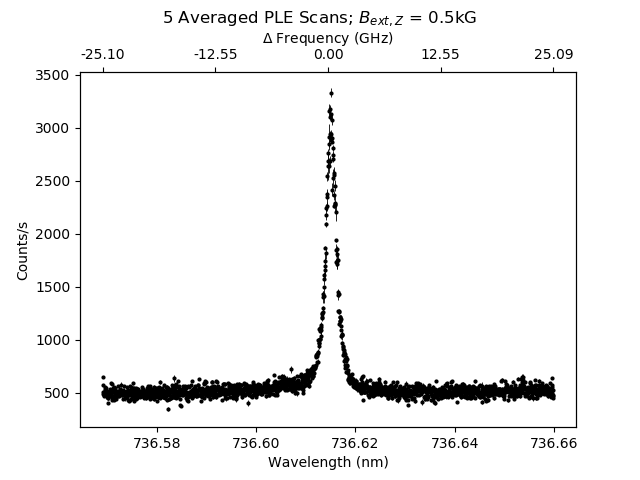

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


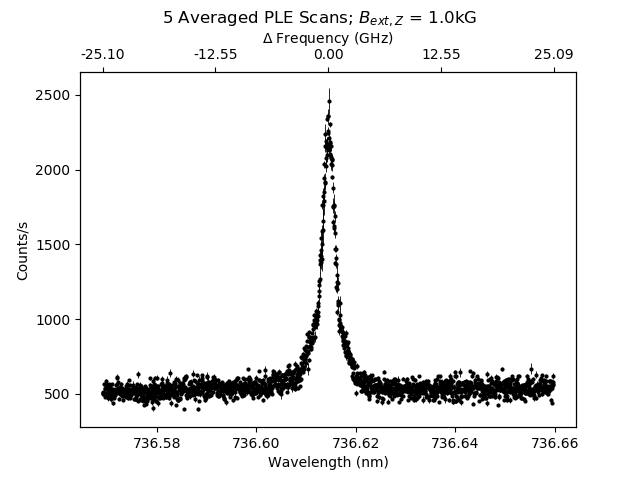

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


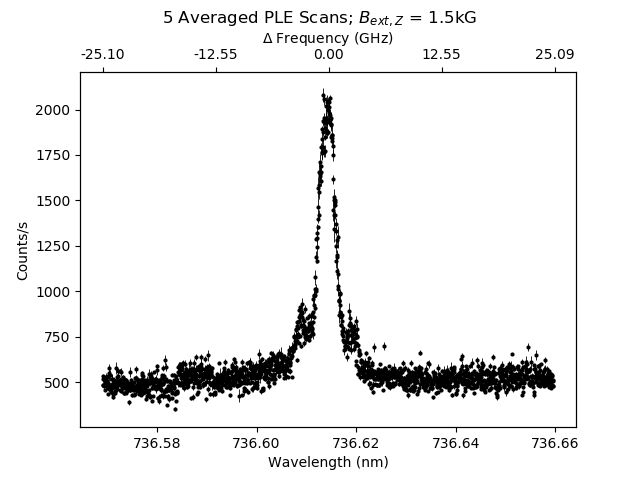

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


<IPython.core.display.Javascript object>


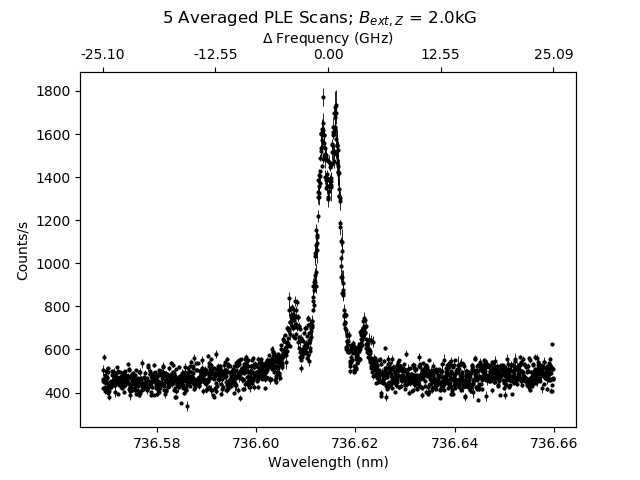

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


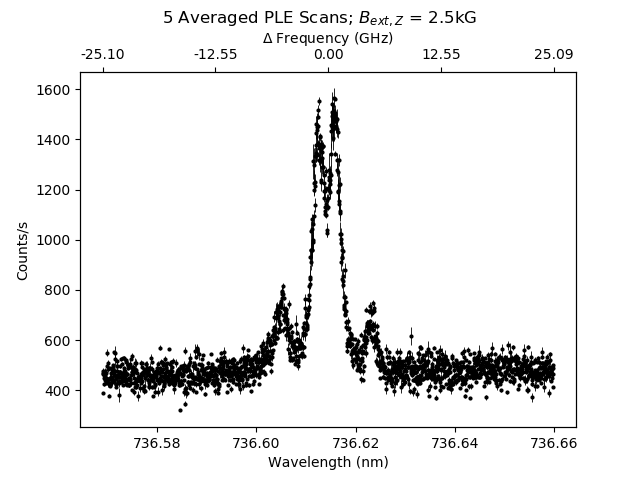

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


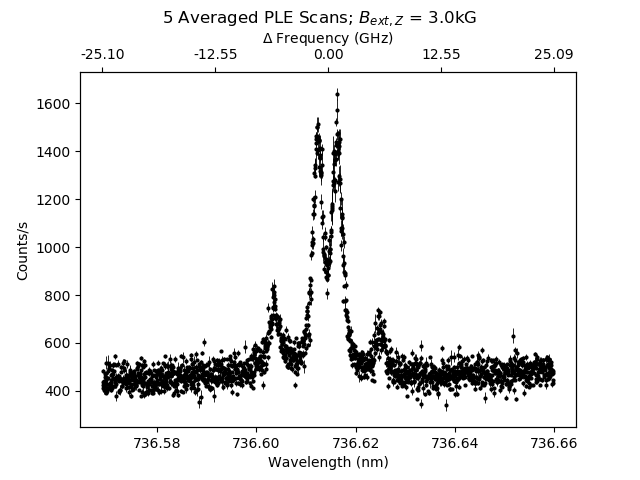

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


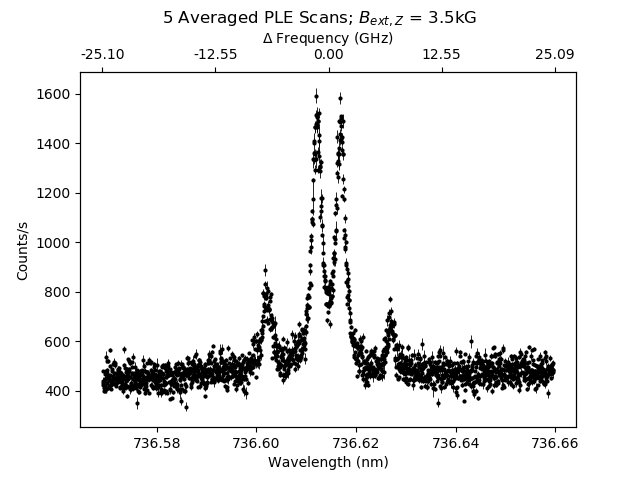

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


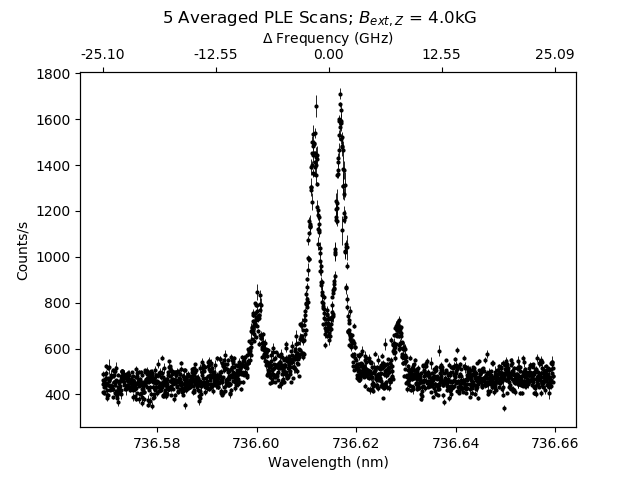

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


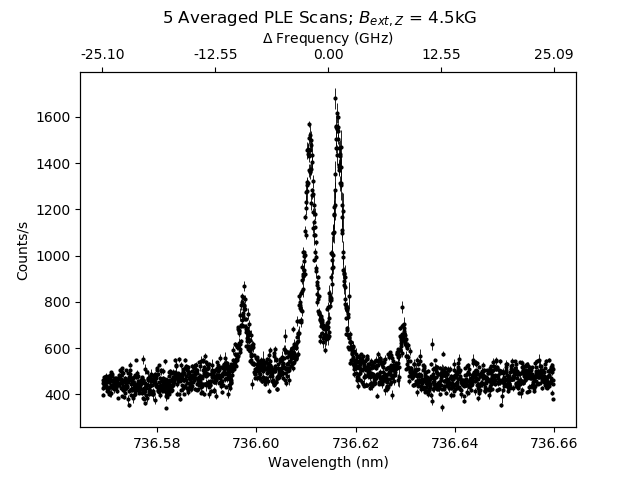

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


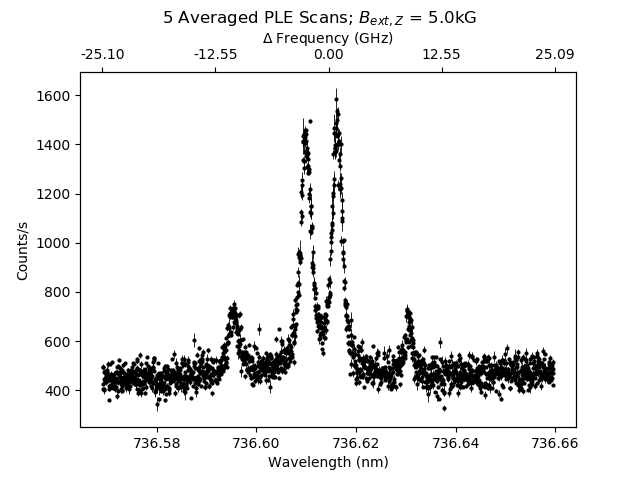

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


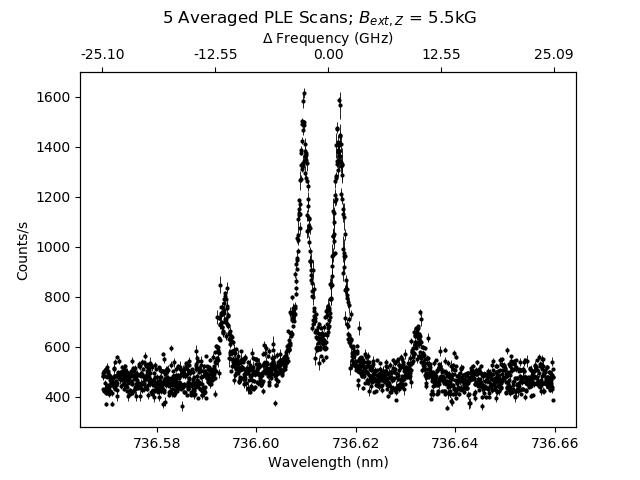

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


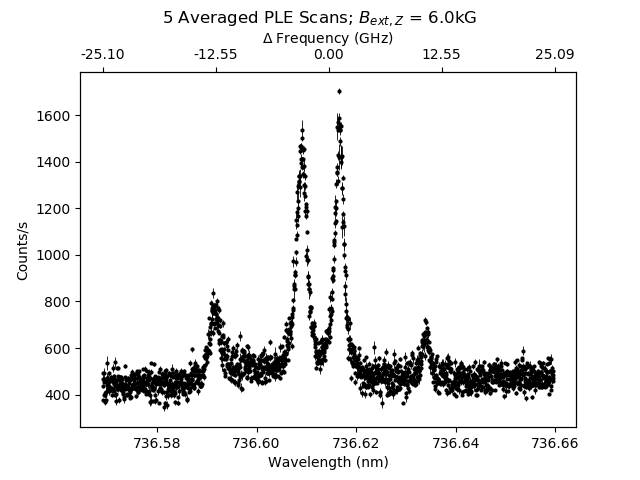

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


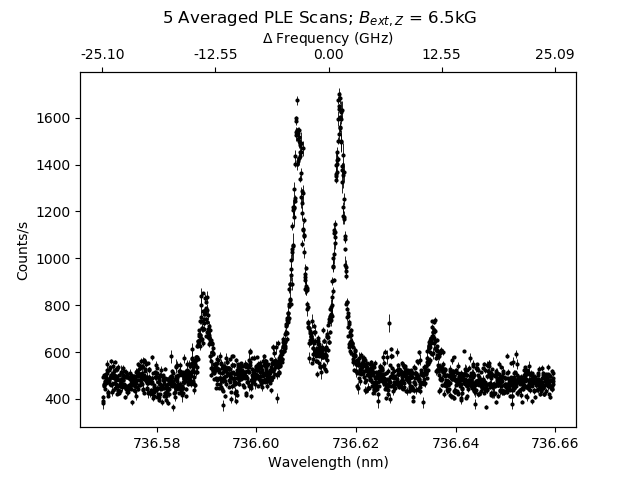

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


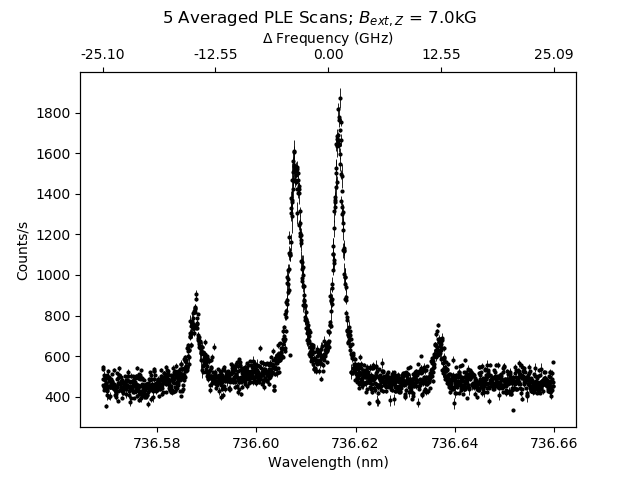

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


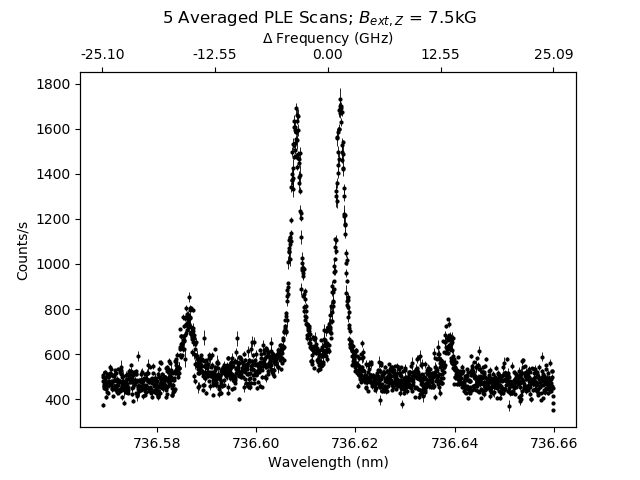

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


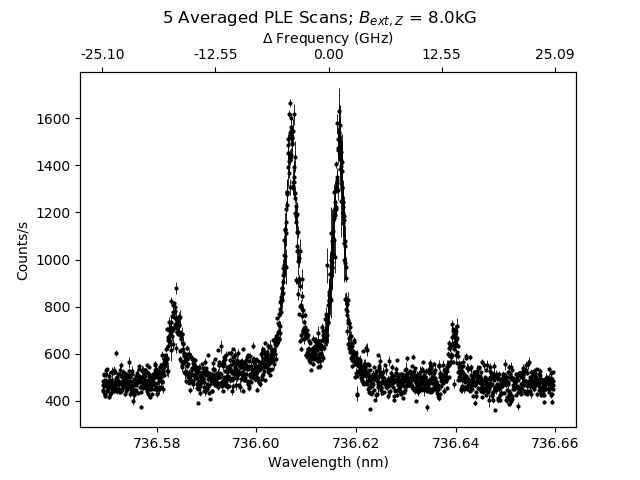

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


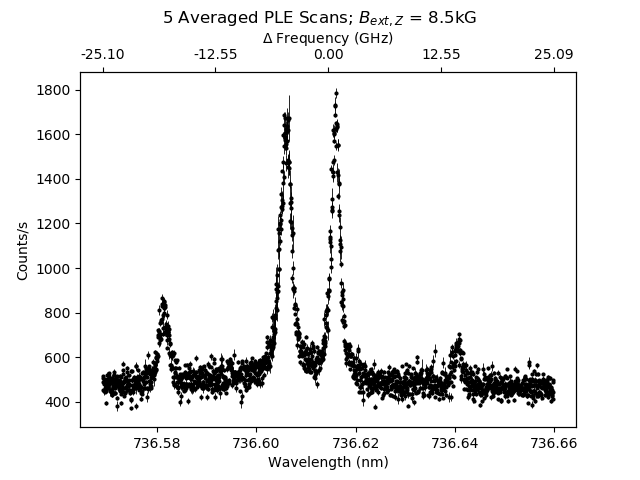

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


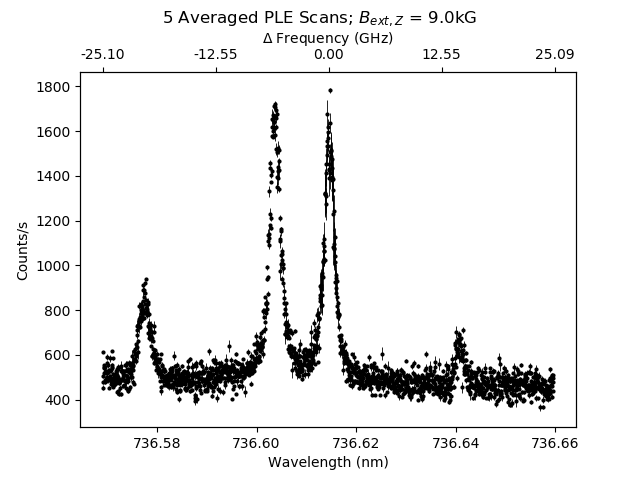

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


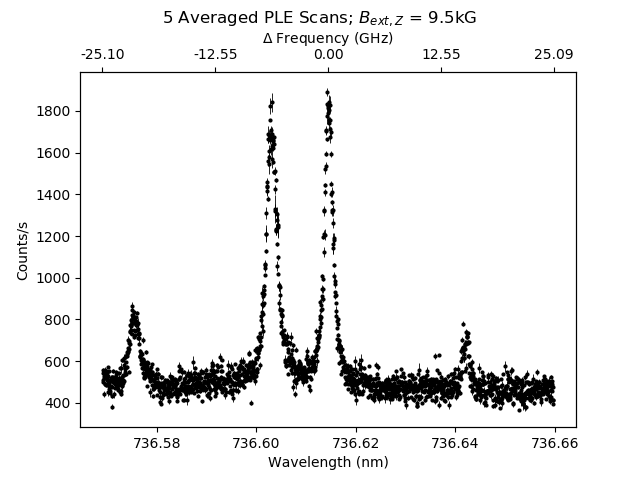

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


C:\Users\loncargroup\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\loncargroup\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


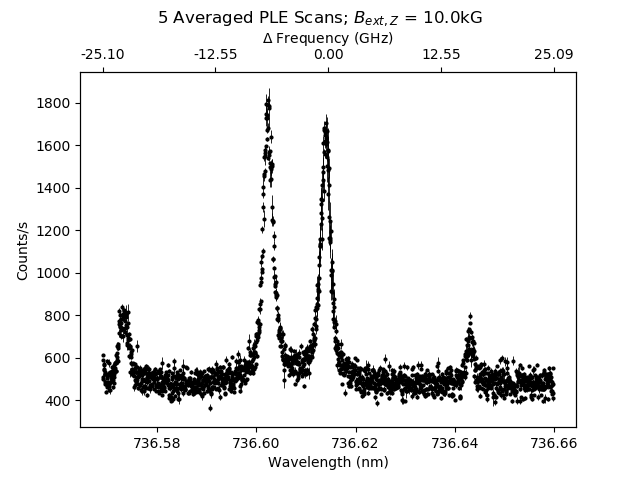

[736.56906 736.59177 736.61448 736.63719 736.6599 ]


In [21]:
#Get dmin, dmax, bn from all of the datasets
dmin, dmax, bn = limitvals(datsuperlist)
if bin_num != 0 and bin_num < bn:
    bn = bin_num

if x_wavelength: 
    xaxstr = "x-wavelength"
else: 
    xaxstr = "x-freq"
    
title_str = title_date_str + '_' + title_str + '_'+ xaxstr + "_binnum-"+ str(bn)

sm_arrays = dict()

for m, fld in enumerate(fields):
    dlist = datsuperlist[m]
    numScans = len(dlist)
    
    sm, xs = smoosh_arrays(dlist, dmin, dmax, bn)
    means = np.nanmean(sm, axis=0)
    stds = np.nanstd(sm, axis=0)/np.sqrt(len(dlist))

    plot_individual_figure(fld, numScans, xs, means, stds) 
    #sm_arrays[fld] = means
